In [5]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode(connected=True)
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pandas.tseries.offsets import *
%matplotlib inline

# 1.特徴量作成

In [7]:
log = pd.read_csv('log.tsv',delimiter="\t")
events = pd.read_csv('events.tsv', delimiter="\t")
users = pd.read_csv('users.tsv', delimiter="\t")
os.chdir('..')

In [8]:
print(log.shape)
log.head()

(1452089, 7)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price
0,1,6261,2015-03-19 09:15:50,3,1.0,クレカ,4000.0
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN
3,1,125296,2017-06-06 14:01:27,1,NaN,NaN,NaN
4,1,125128,2017-06-06 14:03:57,1,NaN,NaN,NaN


In [9]:
print(events.shape)
events.head()

(158392, 11)


,event_id,female_age_lower,female_age_upper,male_age_lower,male_age_upper,event_start_at,prefecture,first_published_at,female_price,male_price,interest
0,1,20,99.0,25,44.0,2015-03-08 18:00:00,宮城県,NaN,1500.0,5000.0,NaN
1,2,30,99.0,30,49.0,2015-03-01 15:00:00,富山県,NaN,1000.0,6500.0,NaN
2,3,22,99.0,24,39.0,2015-03-07 19:00:00,富山県,NaN,1000.0,6000.0,NaN
3,4,20,99.0,25,44.0,2015-03-08 18:00:00,新潟県,NaN,1000.0,6000.0,NaN
4,5,20,99.0,20,39.0,2015-03-14 19:00:00,新潟県,NaN,1000.0,6000.0,NaN


In [10]:
print(users.shape)
users.head()

(69667, 5)


,user_id,age,gender,prefecture,created_on
0,1,34,女性,静岡県,2012-06-26
1,2,31,男性,鳥取県,2012-07-12
2,3,32,男性,東京都,2012-07-15
3,4,30,男性,東京都,2012-07-17
4,5,29,女性,埼玉県,2012-07-17


データ連結

In [11]:
merge1 = pd.merge(log,events, on ="event_id") 

In [12]:
merge2 = pd.merge(merge1,users, on ="user_id")

In [13]:
print(merge2.shape)
merge2.head()

(1450405, 21)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,event_start_at,prefecture_x,first_published_at,female_price,male_price,interest,age,gender,prefecture_y,created_on
0,1,6261,2015-03-19 09:15:50,3,1.0,クレカ,4000.0,27,39.0,27,...,2015-03-22 14:00:00,東京都,NaN,4000.0,6500.0,NaN,34,女性,静岡県,2012-06-26
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26


# 特徴量を数値化

### 時間を数値化

In [14]:
merge2["time_stamp"] = pd.to_datetime(merge2["time_stamp"])

In [15]:
merge2["event_start_at"] = pd.to_datetime(merge2["event_start_at"])

In [16]:
merge2["first_published_at"] = pd.to_datetime(merge2["first_published_at"])

In [17]:
merge2["created_on"] = pd.to_datetime(merge2["created_on"])

In [18]:
print(merge2.shape)
merge2.head()

(1450405, 21)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,event_start_at,prefecture_x,first_published_at,female_price,male_price,interest,age,gender,prefecture_y,created_on
0,1,6261,2015-03-19 09:15:50,3,1.0,クレカ,4000.0,27,39.0,27,...,2015-03-22 14:00:00,東京都,NaT,4000.0,6500.0,NaN,34,女性,静岡県,2012-06-26
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26


### データを数値にする

下の処理に約3分

In [19]:
merge2 = merge2.replace("クレカ", 0)
merge2 = merge2.replace("コンビニ", 1)
merge2 = merge2.replace("eマネー", 2)
print(merge2.shape)
merge2.head()

(1450405, 21)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,event_start_at,prefecture_x,first_published_at,female_price,male_price,interest,age,gender,prefecture_y,created_on
0,1,6261,2015-03-19 09:15:50,3,1.0,0,4000.0,27,39.0,27,...,2015-03-22 14:00:00,東京都,NaT,4000.0,6500.0,NaN,34,女性,静岡県,2012-06-26
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26


下の処理に約2分

In [20]:
merge2 = merge2.replace("女性", 1)
merge2 = merge2.replace("男性", 2)
print(merge2.shape)
merge2.head()

(1450405, 21)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,event_start_at,prefecture_x,first_published_at,female_price,male_price,interest,age,gender,prefecture_y,created_on
0,1,6261,2015-03-19 09:15:50,3,1.0,0,4000.0,27,39.0,27,...,2015-03-22 14:00:00,東京都,NaT,4000.0,6500.0,NaN,34,1,静岡県,2012-06-26
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,1,静岡県,2012-06-26
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,1,静岡県,2012-06-26
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,1,静岡県,2012-06-26
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,1,静岡県,2012-06-26


In [21]:
merge2 = merge2.replace("北海道", 1)
merge2 = merge2.replace("青森県", 2)
merge2 = merge2.replace("岩手県", 3)
merge2 = merge2.replace("宮城県", 4)
merge2 = merge2.replace("秋田県", 5)
merge2 = merge2.replace("山形県", 6)
merge2 = merge2.replace("福島県", 7)
merge2 = merge2.replace("茨城県", 8)
merge2 = merge2.replace("栃木県", 9)
merge2 = merge2.replace("群馬県", 10)
merge2 = merge2.replace("埼玉県", 11)
merge2 = merge2.replace("千葉県", 12)
merge2 = merge2.replace("東京都", 13)
merge2 = merge2.replace("神奈川県", 14)
merge2 = merge2.replace("新潟県", 15)
merge2 = merge2.replace("富山県", 16)
merge2 = merge2.replace("石川県", 17)
merge2 = merge2.replace("福井県", 18)
merge2 = merge2.replace("山梨県", 19)
merge2 = merge2.replace("長野県", 20)
merge2 = merge2.replace("岐阜県", 21)
merge2 = merge2.replace("静岡県", 22)
merge2 = merge2.replace("愛知県", 23)
merge2 = merge2.replace("三重県", 24)
merge2 = merge2.replace("滋賀県", 25)
merge2 = merge2.replace("京都府", 26)
merge2 = merge2.replace("大阪府", 27)
merge2 = merge2.replace("兵庫県", 28)
merge2 = merge2.replace("奈良県", 29)
merge2 = merge2.replace("和歌山県", 30)
merge2 = merge2.replace("鳥取県", 31)
merge2 = merge2.replace("島根県", 32)
merge2 = merge2.replace("岡山県", 33)
merge2 = merge2.replace("広島県", 34)
merge2 = merge2.replace("山口県", 35)
merge2 = merge2.replace("徳島県", 36)
merge2 = merge2.replace("香川県", 37)
merge2 = merge2.replace("愛媛県", 38)
merge2 = merge2.replace("高知県", 39)
merge2 = merge2.replace("福岡県", 40)
merge2 = merge2.replace("佐賀県", 41)
merge2 = merge2.replace("長崎県", 42)
merge2 = merge2.replace("熊本県", 43)
merge2 = merge2.replace("大分県", 44)
merge2 = merge2.replace("宮城県", 45)
merge2 = merge2.replace("鹿児島県", 46)
merge2 = merge2.replace("沖縄県", 47)

In [22]:
print(merge2.shape)
merge2.head()

(1450405, 21)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,event_start_at,prefecture_x,first_published_at,female_price,male_price,interest,age,gender,prefecture_y,created_on
0,1,6261,2015-03-19 09:15:50,3,1.0,0,4000.0,27,39.0,27,...,2015-03-22 14:00:00,13,NaT,4000.0,6500.0,NaN,34,1,22,2012-06-26
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,11,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,1,22,2012-06-26
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,11,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,1,22,2012-06-26
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,11,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,1,22,2012-06-26
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,11,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,1,22,2012-06-26


In [23]:
len(merge2)

1450405

In [24]:
features = ["female_age_lower","female_age_upper","male_age_lower","male_age_upper","female_price","male_price","age", "gender"]
target = ["action_type"]

categorical = ["event_prefecture", "gender", "user_prefecture", 'event_year',"event_month","event_day","event_weekday", "event_hour", "user_year", "user_month"]

In [25]:
data =merge2[features + target]
#naの行消す
data = data.dropna()
data = data.reset_index(drop=True)
print(data.shape)
data.head()

(1442610, 9)


,female_age_lower,female_age_upper,male_age_lower,male_age_upper,female_price,male_price,age,gender,action_type
0,27,39.0,27,39.0,4000.0,6500.0,34,1,3
1,24,36.0,26,38.0,2000.0,6000.0,34,1,1
2,24,36.0,26,38.0,2000.0,6000.0,34,1,1
3,24,36.0,26,38.0,2000.0,6000.0,34,1,1
4,24,36.0,26,38.0,2000.0,6000.0,34,1,1


In [26]:
X = data[features]
print(X.shape)
X.head()

(1442610, 8)


,female_age_lower,female_age_upper,male_age_lower,male_age_upper,female_price,male_price,age,gender
0,27,39.0,27,39.0,4000.0,6500.0,34,1
1,24,36.0,26,38.0,2000.0,6000.0,34,1
2,24,36.0,26,38.0,2000.0,6000.0,34,1
3,24,36.0,26,38.0,2000.0,6000.0,34,1
4,24,36.0,26,38.0,2000.0,6000.0,34,1


In [27]:
y = data.loc[:,target]
print(y.shape)
y.head()

(1442610, 1)


,action_type
0,3
1,1
2,1
3,1
4,1


### 学習

train valid分割

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_valid,y_train, y_valid = train_test_split(
    X,y, test_size=0.3, random_state=0)

モデル構築

In [30]:
reg = xgb.XGBRegressor()

In [63]:
reg_cv = GridSearchCV(reg,  {'learning_rate':[0.5,0.1], 'max_depth':[5,10], 'subsample':[0.5,1.0],'n_estimators':[50,100],
                             'colsample_bytree':[0.5,0.75,1.0]}, verbose=1)
reg_cv.fit(X_train, y_train)
print( reg_cv.best_params_, reg_cv.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 127.7min finished


{'colsample_bytree': 0.75, 'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0} 0.13850212877391996


In [31]:
reg_cv = GridSearchCV(reg,  {'learning_rate':[0.5], 'max_depth':[10], 'subsample':[1.0],'n_estimators':[100],
                             'colsample_bytree':[0.75]}, verbose=1)
reg_cv.fit(X_train, y_train)
print( reg_cv.best_params_, reg_cv.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished


{'colsample_bytree': 0.75, 'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0} 0.13850212877391996


In [32]:
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

# 評価（train,validデータに対してaction_typeとの比較）

In [33]:
pred_train = reg.predict(X_train)
pred_valid = reg.predict(X_valid)

評価

In [34]:
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, pred_train), mean_squared_error(y_valid, pred_valid)) )
# R^2
from sklearn.metrics import r2_score
print('R^2 train : %.3f, test : %.3f' % (r2_score(y_train, pred_train), r2_score(y_valid, pred_valid)) )

MSE train : 0.477, test : 0.504
R^2 train : 0.193, test : 0.148


プロット

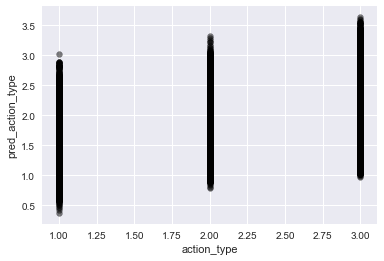

In [69]:
plt.scatter(y_train["action_type"],pred_train, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.xlabel('action_type')
plt.ylabel('pred_action_type')

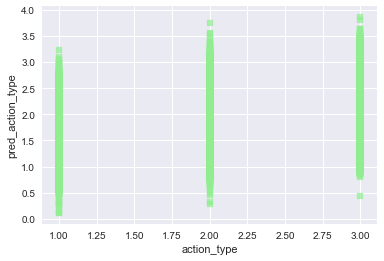

In [70]:
plt.scatter(y_valid["action_type"],pred_valid,  c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Valid data')
plt.xlabel('action_type')
plt.ylabel('pred_action_type')

比較的、action_typeが大きいものは、値が大きい
ばらつきは同じくらい

typeとcolumn変更

In [50]:
Pred_train = pd.DataFrame(pred_train)
Pred_train = Pred_train.rename( columns = { 0 : "pred_action_type" } )
print(Pred_train.shape)
Pred_train

(1009827, 1)


,pred_action_type
0,1.677374
1,1.553619
2,2.259753
3,1.750549
4,1.389678
5,1.726537
6,1.725479
7,2.711325
8,1.506467
9,1.524874


In [51]:
Pred_valid = pd.DataFrame(pred_valid)
Pred_valid = Pred_valid.rename( columns = { 0 : "pred_action_type" } )
print(Pred_valid.shape)
Pred_valid

(432783, 1)


,pred_action_type
0,1.557948
1,2.103818
2,1.727085
3,1.783763
4,1.424491
5,1.407762
6,1.741222
7,1.435132
8,1.807732
9,1.413808


index調整

In [62]:
Pred_train.index = y_train.index

In [65]:
Pred_valid.index = y_valid.index

In [72]:
TRAIN =pd.concat([y_train["action_type"],Pred_train["pred_action_type"]],axis=1)

In [73]:
VALID =pd.concat([y_valid["action_type"],Pred_valid["pred_action_type"]],axis=1)

In [77]:
Result =pd.concat([TRAIN,VALID],axis=0).sort_index(ascending=True)

# action_typeとpred_action_typeを比較

In [78]:
Result

,action_type,pred_action_type
0,3,2.254148
1,1,1.301268
2,1,1.301268
3,1,1.301268
4,1,1.301268
5,1,1.301268
6,1,1.301268
7,1,1.301268
8,1,1.301268
9,1,1.301268


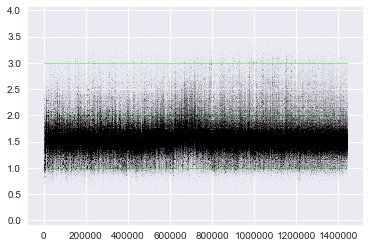

In [89]:
plt.scatter(Result.index,Result["action_type"],  c = 'lightgreen', marker = 's', s = 1 ,alpha = 0.01,)
plt.scatter(Result.index,Result["pred_action_type"],  c = 'black', marker = 's', s = 1, alpha = 0.01,)
#plt.xlabel('action_type')
#plt.ylabel('pred_action_type')

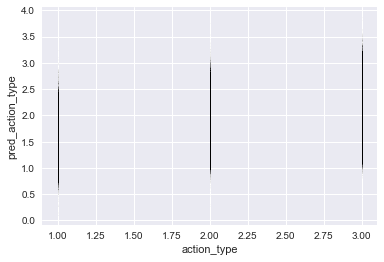

In [91]:
plt.scatter(Result["action_type"],Result["pred_action_type"],  c = 'black', marker = 's', s = 1, alpha = 0.01,)
plt.xlabel('action_type')
plt.ylabel('pred_action_type')

Ｆ値

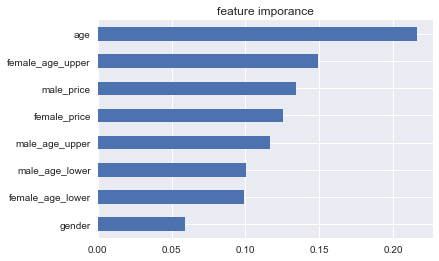

In [79]:
importances = pd.Series(reg.feature_importances_, index = X_train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("feature imporance")
plt.show()

年齢と女性の上限の年齢の重要度高い…つらい

In [ ]:
test = pd.read_csv("test.tsv", delimiter="\t")
events = pd.read_csv("events.tsv", delimiter="\t")

In [ ]:
print(users.shape)
users.head()

In [ ]:
user_list = test["user_id"]
event_list = events["event_id"]

ユーザー１に対して